In [ ]:
from PIL import Image
import PIL.ImageOps

from collections import defaultdict
from glob import glob
from random import shuffle, seed
import numpy as np
import pylab as pl
import pandas as pd
import re
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import LogisticRegression

# this is the size of all the Target.com images
STANDARD_SIZE = (138,138)
HALF_SIZE = (STANDARD_SIZE[0]/2,STANDARD_SIZE[1]/2)

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl

In [ ]:
img = Image.open(shirt_files[0])
img = img.resize(STANDARD_SIZE)
img = list(img.getdata())
img = map(list, img)

In [ ]:
img = np.array(img)
img.shape

In [ ]:
from PIL import Image
import PIL.ImageOps

from collections import defaultdict
from glob import glob
from random import shuffle, seed
import numpy as np
import pylab as pl
import pandas as pd
import re
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import LogisticRegression

# this is the size of all the Target.com images
STANDARD_SIZE = (138,138)
HALF_SIZE = (STANDARD_SIZE[0]/2,STANDARD_SIZE[1]/2)

    
def img_to_array(filename):
    """
    takes a filename and turns it into a numpy array of RGB pixels
    """
    img = Image.open(filename)
    img = img.resize(STANDARD_SIZE)
    img = list(img.getdata())
    img = map(list, img)
    img = np.array(img)
    s = img.shape[0] * img.shape[1]
    img_wide = img.reshape(1, s)
    return img_wide[0]

# my files are set up like "images/girls/gapkids/image1.jpg" and "images/boys/oldnavy/image1.jpg"
shirt_files = glob('./Shirt/*')
jersey_files = glob('./Jersey/*')

process_file = img_to_array

raw_data = []
for filename in shirt_files:
    print filename
    raw_data.append((process_file(filename),'shirt',filename))
for filename in jersey_files:
    print filename
    raw_data.append((process_file(filename),'jersey',filename))
    
# raw_data = [(process_file(filename),'girl',filename) ] + \
#            [(process_file(filename),'boy',filename) for filename in boys_files]


# randomly order the data
seed(0)
shuffle(raw_data)

# pull out the features and the labels
data = np.array([cd for (cd,_y,f) in raw_data])
labels = np.array([_y for (cd,_y,f) in raw_data])

# find the principal components
N_COMPONENTS = 10
pca = RandomizedPCA(n_components=N_COMPONENTS, random_state=0)
X = pca.fit_transform(data)
y = [1 if label == 'shirt' else 0 for label in labels]


In [ ]:
print len(boys_files)

In [ ]:
raw_data = []
for filename in shirt_files:
    print filename
    raw_data.append((process_file(filename),'shirt',filename))
for filename in jersey_files:
    print filename
    raw_data.append((process_file(filename),'jersey',filename))
    
# raw_data = [(process_file(filename),'girl',filename) ] + \
#            [(process_file(filename),'boy',filename) for filename in boys_files]



In [ ]:
# randomly order the data
seed(0)
shuffle(raw_data)

# pull out the features and the labels
data = np.array([cd for (cd,_y,f) in raw_data])
labels = np.array([_y for (cd,_y,f) in raw_data])



In [ ]:
from scipy.misc import imresize

In [ ]:
# find the principal components
N_COMPONENTS = 10
pca = RandomizedPCA(n_components=N_COMPONENTS, random_state=0)
X = data
y = [1 if label == 'shirt' else 0 for label in labels]


In [ ]:

def image_from_component(component):
    """takes one of the principal components and turns it into an image"""
    hi = max(component)
    lo = min(component)
    n = len(component) / 3
    def rescale(x):
        return int(255 * (x - lo) / (hi - lo))
    d = [(rescale(component[3 * i]),
          rescale(component[3 * i + 1]),
          rescale(component[3 * i + 2])) for i in range(n)]
    im = Image.new('RGB',STANDARD_SIZE)
    im.putdata(d)
    return im

# write out each eigenshirt and the shirts that 
for i,component in enumerate(pca.components_):
    img = image_from_component(component)
    img.save(str(i) + "_eigenshirt.png")
    reverse_img = PIL.ImageOps.invert(img)
    reverse_img.save(str(i) + "_inverted_eigenshirt.png")

    ranked_shirts = sorted(enumerate(X),
           key=lambda (a,x): x[i])
    most_i = ranked_shirts[-1][0]
    least_i = ranked_shirts[0][0]
    ranked_shirts.sort(key=lambda (a,x): abs(x[i]))
    no_i = ranked_shirts[0][0]

    Image.open(raw_data[most_i][2]).save(str(i) + "_most.png")
    Image.open(raw_data[least_i][2]).save(str(i) + "_least.png")
    Image.open(raw_data[no_i][2]).save(str(i) + "_none.png")

def reconstruct(shirt_number):
    """this was my attempt to reconstruct shirts from their first 10 principal components
    but they don't look like much of anything"""
    components = pca.components_
    eigenvalues = X[shirt_number]
    eigenzip = zip(eigenvalues,components)
    N = len(components[0])    
    r = [int(sum([w * c[i] for (w,c) in eigenzip]))
                     for i in range(N)]
    d = [(r[3 * i], r[3 * i + 1], r[3 * i + 2]) for i in range(len(r) / 3)]
    img = Image.new('RGB',STANDARD_SIZE)
    img.putdata(d)
    print raw_data[shirt_number][2]
    img.save('reconstruct.png')

#find and reconstruct the monkey shirt:
monkey_index = [i for (i,(cd,_y,f)) in enumerate(raw_data) if '243A637' in f]
reconstruct(282)
    
#
# and now for some predictive modeling

# split the data into a training set and a test set
train_split = int(len(data) * 4.0 / 5.0)

X_train = X[:train_split]
X_test = X[train_split:]
y_train = y[:train_split]
y_test = y[train_split:]

# if you wanted to use a different model, you'd specify that here
clf = LogisticRegression(penalty='l2')
clf.fit(X_train,y_train)

print "score",clf.score(X_test,y_test)
    


In [ ]:
# and now some qualitative results

# first, let's find the model score for every shirt in our dataset
probs = zip(clf.decision_function(X),raw_data)

girliest_girl_shirt = sorted(probs,key=lambda (p,(cd,g,f)): (0 if g == 'girl' else 1,p))[0]
girliest_boy_shirt = sorted(probs,key=lambda (p,(cd,g,f)): (0 if g == 'boy' else 1,p))[0]
boyiest_girl_shirt = sorted(probs,key=lambda (p,(cd,g,f)): (0 if g == 'girl' else 1,-p))[0]
boyiest_boy_shirt = sorted(probs,key=lambda (p,(cd,g,f)): (0 if g == 'boy' else 1,-p))[0]
most_androgynous_shirt = sorted(probs,key=lambda (p,(cd,g,f)): abs(p))[0]

# and let's look at the most and least extreme shirts
cd = zip(X,raw_data)
least_extreme_shirt = sorted(cd,key=lambda (x,(d,g,f)): sum([abs(c) for c in x]))[0]
most_extreme_shirt =  sorted(cd,key=lambda (x,(d,g,f)): sum([abs(c) for c in x]),reverse=True)[0]

least_interesting_shirt = sorted(cd,key=lambda (x,(d,g,f)): max([abs(c) for c in x]))[0]
most_interesting_shirt =  sorted(cd,key=lambda (x,(d,g,f)): min([abs(c) for c in x]),reverse=True)[0]

# and now let's look at precision-recall
probs = zip(clf.decision_function(X_test),raw_data[train_split:])
num_boys = len([c for c in y_test if c == 1])
num_girls = len([c for c in y_test if c == 0])
lowest_score = round(min([p[0] for p in probs]),1) - 0.1
highest_score = round(max([p[0] for p in probs]),1) + 0.1
INTERVAL = 0.1

# first do the girls
score = lowest_score
while score <= highest_score:
    true_positives  = len([p for p in probs if p[0] <= score and p[1][1] == 'girl'])
    false_positives = len([p for p in probs if p[0] <= score and p[1][1] == 'boy'])
    positives = true_positives + false_positives
    if positives > 0:
        precision = 1.0 * true_positives / positives
        recall = 1.0 * true_positives / num_girls
        print "girls",score,precision,recall
    score += INTERVAL

# then do the boys
score = highest_score
while score >= lowest_score:
    true_positives  = len([p for p in probs if p[0] >= score and p[1][1] == 'boy'])
    false_positives = len([p for p in probs if p[0] >= score and p[1][1] == 'girl'])
    positives = true_positives + false_positives
    if positives > 0:
        precision = 1.0 * true_positives / positives
        recall = 1.0 * true_positives / num_boys
        print "boys",score,precision,recall
    score -= INTERVAL

# now do both
score = lowest_score
while score <= highest_score:
    girls  = len([p for p in probs if p[0] <= score and p[1][1] == 'girl'])
    boys = len([p for p in probs if p[0] <= score and p[1][1] == 'boy'])
    print score, girls, boys
    score += INTERVAL


In [ ]:
def plot_data(lda, X, y, y_pred, fig_index):
    fig = plt.figure(figsize=(15,10))
    splot = plt.subplot(1,1,fig_index)
    
    if fig_index == 1:
        plt.title('Linear Discriminant Analysis')
        plt.ylabel('Data with\n fixed covariance')
    elif fig_index == 2:
        plt.title('Quadratic Discriminant Analysis')
    elif fig_index == 3:
        plt.ylabel('Data with\n varying covariances')
    y = np.array(y)
    tp = (y == y_pred)  # True Positive
#     tp= tp.reshape((len(tp),1))
    print y == 0
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    alpha = 0.5

    # class 0: dots
    plt.plot(X0_tp[:, 0], X0_tp[:, 1], 'o', alpha=alpha,
             color='red', markeredgecolor='k')
    plt.plot(X0_fp[:, 0], X0_fp[:, 1], '*', alpha=alpha,
             color='#990000', markeredgecolor='k')  # dark red

    # class 1: dots
    plt.plot(X1_tp[:, 0], X1_tp[:, 1], 'o', alpha=alpha,
             color='blue', markeredgecolor='k')
    plt.plot(X1_fp[:, 0], X1_fp[:, 1], '*', alpha=alpha,
             color='#000099', markeredgecolor='k')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    print X.shape
    print np.c_[xx.ravel(), yy.ravel()].shape
#     Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z[:, 1].reshape(xx.shape)
#     plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
#                    norm=colors.Normalize(0., 1.))
#     plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='k')

    # means
    plt.plot(lda.means_[0][0], lda.means_[0][1],
             'o', color='black', markersize=10, markeredgecolor='k')
    plt.plot(lda.means_[1][0], lda.means_[1][1],
             'o', color='black', markersize=10, markeredgecolor='k')

    return splot

In [ ]:
def plot_ellipse(splot, mean, cov, color):
    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='yellow',
                              linewidth=2, zorder=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
for i, (X, y) in enumerate([[X,y]]):
    # Linear Discriminant Analysis
    
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True, n_components=1000)
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)
    plot_lda_cov(lda, splot)
    plt.axis('tight') 
    

In [ ]:
# split the data into a training set and a test set
X = data
y = [1 if label == 'shirt' else 0 for label in labels]

train_split = int(len(data) * 4.0 / 5.0)
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True, n_components=1000)
X = lda.fit_transform(X, y)
X_train = X[:train_split]
X_test = X[train_split:]
y_train = y[:train_split]
y_test = y[train_split:]

# if you wanted to use a different model, you'd specify that here
clf = LogisticRegression(penalty='l2')
clf.fit(X_train,y_train)

print "score",clf.score(X_test,y_test)

In [ ]:
# split the data into a training set and a test set
train_split = int(len(data) * 4.0 / 5.0)
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True, n_components=1)
X = lda.fit_transform(X, y)
X_train = X[:train_split]
X_test = X[train_split:]
y_train = y[:train_split]
y_test = y[train_split:]

# if you wanted to use a different model, you'd specify that here
clf = LogisticRegression(penalty='l2')
clf.fit(X_train,y_train)

print "score",clf.score(X_test,y_test)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
for i, (X, y) in enumerate([[X,y]]):
    # Linear Discriminant Analysis
    
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True, n_components=1)
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)
    plot_lda_cov(lda, splot)
    plt.axis('tight')

In [ ]:
for i in enumerate([[X,y]]):
    print i

In [ ]:
np.r_[-1:1:6j, [0]*3, 5, 6]

In [20]:
from PIL import Image
import PIL.ImageOps
from glob import glob
from random import shuffle, seed
import numpy as np
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
# this is the size of all the Target.com images
STANDARD_SIZE = (138,138)
HALF_SIZE = (STANDARD_SIZE[0]/2,STANDARD_SIZE[1]/2)

    
def img_to_array(filename):
    """
    Takes a filename and turns it into a 1D numpy array of RGB pixels
    """
    img = Image.open(filename)
    
    img = img.resize(STANDARD_SIZE)
    print np.array(img.getdata()).shape
    img = list(img.getdata())
    print np.array(img).shape
    img = map(list, img)
    img = np.array(img)
    print img.shape
    s = img.shape[0] * img.shape[1]
    print s
    img_wide = img.reshape(1, s)
    return img_wide[0]

# my files are set up like "images/girls/gapkids/image1.jpg" and "images/boys/oldnavy/image1.jpg"
male_files = glob('./Male/*')
female_files = glob('./Female/*')

process_file = img_to_array

In [21]:
img_to_array(male_files[0])

(19044, 3)
(19044, 3)
(19044, 3)
57132


array([3, 1, 2, ..., 6, 6, 8])

Automatically created module for IPython interactive environment
Dataset consists of 400 faces
Extracting the top 6 Eigenfaces - PCA using randomized SVD...
done in 0.105s
Extracting the top 6 Non-negative components - NMF...
done in 0.756s
Extracting the top 6 Independent components - FastICA...
done in 0.208s
Extracting the top 6 Sparse comp. - MiniBatchSparsePCA...
done in 1.609s
Extracting the top 6 MiniBatchDictionaryLearning...
done in 0.753s
Extracting the top 6 Cluster centers - MiniBatchKMeans...
done in 0.213s
Extracting the top 6 Factor Analysis components - FA...
done in 0.127s


/Users/alng/anaconda/lib/python2.7/site-packages/sklearn/decomposition/factor_analysis.py:226: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


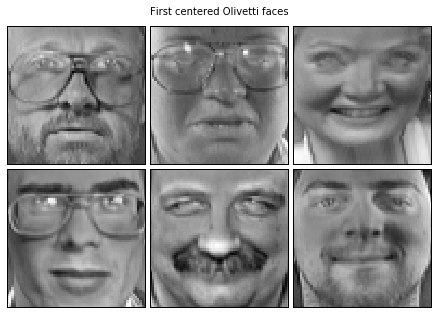

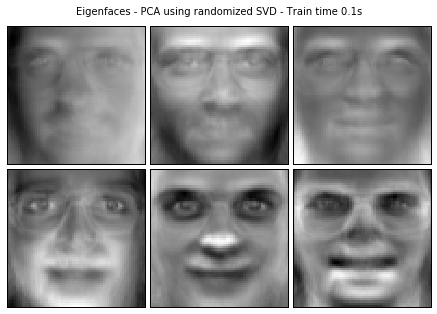

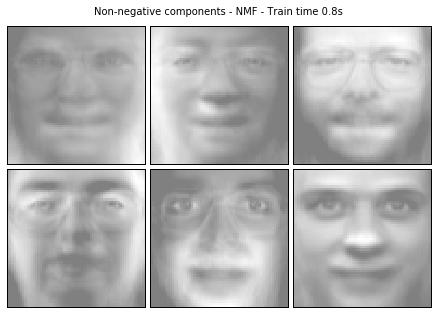

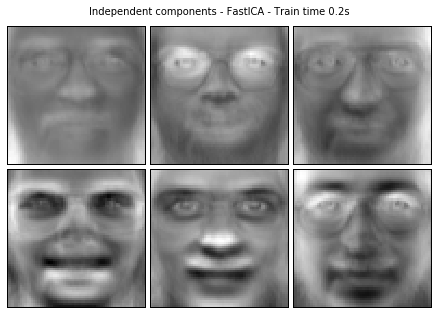

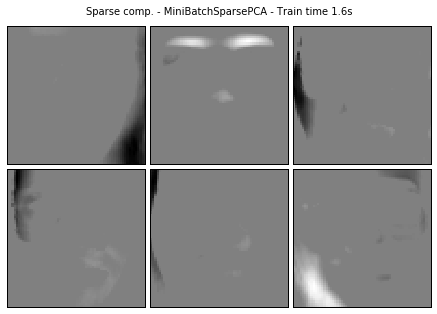

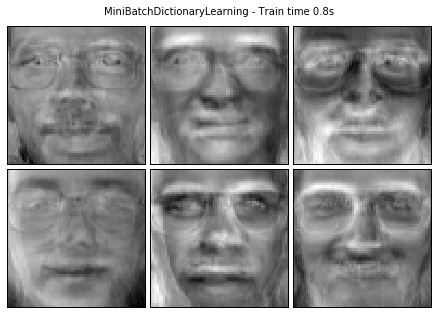

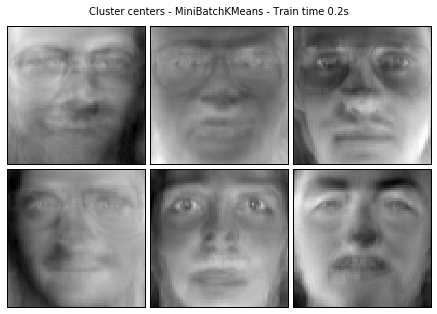

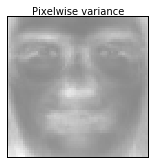

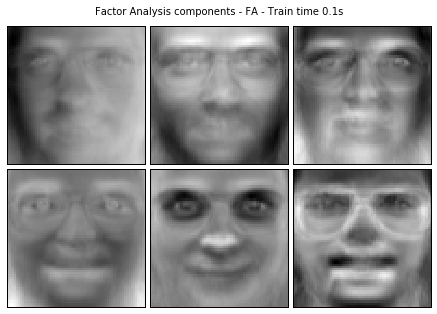

In [11]:
print(__doc__)

# Authors: Vlad Niculae, Alexandre Gramfort
# License: BSD 3 clause

import logging
from time import time

from numpy.random import RandomState
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# #############################################################################
# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)


def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# #############################################################################
# List of the different estimators, whether to center and transpose the
# problem, and whether the transformer uses the clustering API.
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True),

    ('Non-negative components - NMF',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng),
     True),

    ('MiniBatchDictionaryLearning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng),
     True),

    ('Cluster centers - MiniBatchKMeans',
        MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                        max_iter=50, random_state=rng),
     True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=2),
     True),
]


# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# #############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_

    # Plot an image representing the pixelwise variance provided by the
    # estimator e.g its noise_variance_ attribute. The Eigenfaces estimator,
    # via the PCA decomposition, also provides a scalar noise_variance_
    # (the mean of pixelwise variance) that cannot be displayed as an image
    # so we skip it.
    if (hasattr(estimator, 'noise_variance_') and
            estimator.noise_variance_.ndim > 0):  # Skip the Eigenfaces case
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

plt.show()